#Processamento de Linguagem Natural na detecção de Phishing (Versão T3)
Uma solução inteligente no combate de fraudes online
<hr>

### **Autores**

  - Charllynson Carvalho Caxias
  - Fernanda Cardoso Petiz
  - Orientadora: Profª. Brenda Salenave Santana

 O projeto visa criar um modelo robusto e escalável, utilizando ferramentas de Processamento de Linguagem Natural para analisar padrões textuais e identificar indícios de phishing de maneira eficiente em mensagens de e-mails.

### **Dataset utilizado**

O dataset utilizado para testar o modelo  de análise de mensagens foi o "Phishing Email Dataset", de Naser Abdullah Alam, que pode ser encontrado em https://www.kaggle.com/datasets/naserabdullahalam/phishing-email-dataset. Por outro lado, o dataset utilizado para o treinamento do modelo de análise de URL's foi o "Phishing URL dataset", de KAITHOLIKKAL, JISHNU K S; B, Arthi, e pode ser encontrado em https://data.mendeley.com/datasets/vfszbj9b36/1.

### **Features**

- [x] Verifica as palavras mais frequentes de um e-mail com phishing;
- [x] Analisa e representa graficamente os unigramas e bigramas de e-mails com e sem phishing;
- [x] Analisa se as mensagens são autênticas ou falsas (phishing);
- [x] Analisa se as URL's são confiáveis ou perigosas.

### **Release Notes**

Nesta versão, o verificador de URL's foi melhorado. Na versão anterior, a tarefa se dava através de um analisador sintático, sem a intervenção de qualquer modelo, o que gerava resultados não fiéis dada a natureza da URL. Nesta atualização, treinamos um modelo para efetuar esta análise, de maneira que, agora, os resultados gerados são mais assertivos e confiáveis. Além disso, colocamos uma interface para ter uma maior interatividade e uma melhor apresentação do resultado.

### **Passo a passo para execução**

1. Configure o ambiente da seguinte maneira:
 Clique no botão ‘Runtime’, em seguida clique em ‘Change runtime type’. Na seção ‘Runtime type’ selecione Python 3.

2. Clique no botão 'Runtime' e, em seguida, clique em 'Run all' para executar todas as células. Caso deseje exeutar as células separadamente, garanta ter executado as células com importações primeiro e, logo após, as células contendo funções definidas para, então, executar as células que geram algum retorno visual.

## **Imports**

In [5]:
# Pasta no drive contendo arquivo do dataset
!gdown --folder https://drive.google.com/drive/folders/1h2s-KayZxEwW7aiJ5Kqd5fD4UT1nfvSN?usp=sharing

Retrieving folder contents
Processing file 1ld6nU-VM9ZgusJW03Db_2MCLDOqu3nES Legitimate URLs.csv
Processing file 1PmwqNX1fmtX8T00Oy17stFSIW1ir2ZD7 Phishing Email_urls.csv
Processing file 1ccP1hNKjAzZ9MYDwoF09ATZ7GCgi4k6yqq13YJ4rQmk Phishing URLs
Processing file 1Tw8AC9YMfff_xjj3OJoQ9qgE5ogm-M1s Phishing URLs.csv
Processing file 12DX0Wi-kNP6HJ-rytKf-Y6pNO32jhp4C Phishing_Email.csv
Processing file 1csHlx4AxETn3s62ycL_9SblU-DTnNKyd1kQzXqlBj8I PhishngDataset-We application
Processing file 1UUV5nMUUn9r6rkoqUZv91tnQxlNh-8EM Safe Email_urls.csv
Processing file 1T5cSlCIcN9GsXAxBljmqsGiA-FNO7zhdLGde4sOnsf4 train
Processing file 1HvGFbIX-V630ch3ra-arc4YM9DCPpi6A train.csv
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1ld6nU-VM9ZgusJW03Db_2MCLDOqu3nES
To: /content/Dataset/Legitimate URLs.csv
100% 32.3M/32.3M [00:00<00:00, 46.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Pmw

In [6]:
# Importações para todas as células
import nltk
import nltk.tokenize as tk
nltk.download('punkt_tab')

from nltk.corpus import stopwords
nltk.download('stopwords')

import re
import requests

import string
from itertools import groupby

import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from urllib.parse import urlparse

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## **Análise do Dataset e pré-processamento**

In [7]:
# Abrir dataset
import csv, sys
nome_dataset = '/content/Dataset/Phishing_Email.csv'
csv.field_size_limit(sys.maxsize)  # Para conseguir verifcar o dataset todo

131072

In [8]:
def remove_repeating_chars(s):
    return ''.join(char for char, _ in groupby(s))

In [9]:
def contadorFreq(lista):
  contador = Counter()

  for item in lista:
    if len(item) < 15:
      contador[item] +=1

  freq = pd.DataFrame(contador.most_common(100), columns=["words", "count"])
  return freq

In [10]:
def clean_bigrams(bigrams, max_word_length=15):

    cleaned_bigrams = []

    for bigram in bigrams:
        # Separa o bigrama em duas palavras
        word1, word2 = bigram

        # Verifica se as palavras tem um tamanho razoável
        if (len(str(word1)) <= max_word_length and
            len(str(word2)) <= max_word_length and
            # Confere se são caracteres alfanuméricos
            word1.isalnum() and
            word2.isalnum()):

            cleaned_bigrams.append(bigram)

    return cleaned_bigrams

In [11]:
def palavra_mais_frequente(lista):
  maisFrequente = Counter(lista).most_common(1)
  return maisFrequente[0][0]

In [12]:
def plotaGraph(word_freq, titulo):
    plt.style.use("_mpl-gallery")

    x = [str(word) for word in word_freq["words"]]
    y = word_freq["count"]

    fig, ax = plt.subplots(figsize=(12, 6))  # Increased figure size

    ax.bar(x, y, width=0.8, edgecolor="white", linewidth=0.7)

    # Ajustar limites dinamicamente
    ax.set_xlim(-0.5, len(x) - 0.5)  # Ajusta para o número exato de palavras
    ax.set_ylim(0, max(y) + 50)  # Ajusta altura baseada no maior valor

    plt.xticks(rotation=90)  # Mantém legível
    plt.title(titulo)

    plt.show()

In [13]:
def contar_e_plotar(lista):

  contaFreq = contadorFreq(lista)
  plotaGraph(contaFreq, "Unigrama")

  bigrama = list(nltk.bigrams(lista))
  bigrama2 = clean_bigrams(bigrama)
  contaFreq = contadorFreq(bigrama2)
  plotaGraph(contaFreq, "Bigrama")

In [14]:
def conversor_utf8(text, tipo = None):

  clean_text = re.sub(r'[^\x20-\x7E]', '', text)  # Mantém ASCII
  string_nova = re.sub(u'[^a-zA-Z0-9áéíóúÁÉÍÓÚâêîôÂÊÎÔãõÃÕçÇ: ]', '', clean_text) # Remover apóstrofos

  # if tipo == "url":
  #   string_nova = remove_repeating_chars(string_nova)

  return string_nova

In [15]:
def processar_dataset(nome_dataset, tipo_email):
  # Pega as letras
  letters = set(string.ascii_letters)

  # Pega caracteres
  all_chars = set(string.printable)

  # Acha caracteres indesejados
  unwanted_chars = sorted((all_chars | {'â', 'ä' ,'ã', 'á', 'à'} - letters) - {'$', '%'})

  # Regex para url
  url_regex = r"(?P<url>https?://[^\s]+)"
  stop_words = set(stopwords.words('english'))
  tokenized_linha = []
  sub_dataset = []

  with open(nome_dataset, 'r') as dataset:
    reader = csv.reader(dataset)
    for linha in reader:

      # Encontrar email com ou sem phishing
      if (linha[2] == tipo_email):

        # Encontra url
        match_url = re.findall(url_regex, linha[1])

        # Encontra linhas contendo urls
        if match_url:
          # salva urls em um csv
          f = open(tipo_email + '_urls.csv', 'a').write(match_url[0] + "\n")

          dt_limpo = conversor_utf8(linha[1], "url")

          # Tokenização e remoção de stopwords
          tokenized_linha = [word.lower() for word in tk.word_tokenize(dt_limpo) if word not in unwanted_chars]
          tokenized_linha = [word for word in tokenized_linha if word not in stop_words and len(word) > 2]
          for word in tokenized_linha:
            sub_dataset.append(word)

    contar_e_plotar(sub_dataset)

    return sub_dataset


In [16]:
# Função para salvar e-mails de phishing
def processar_phishing(nome_dataset, nome_saida):
    emails_phishing = []

    with open(nome_dataset, 'r') as dataset:
        reader = csv.reader(dataset)
        for linha in reader:
            if linha[2] == "Phishing Email":  # Verifica se o email é de phishing
                texto_limpo = conversor_utf8(linha[1])  # Usa conversor_utf8 para limpar o texto
                emails_phishing.append([texto_limpo])

    # Salva os e-mails de phishing em um novo CSV
    with open(nome_saida, 'w', newline='', encoding='utf-8') as arquivo_saida:
        writer = csv.writer(arquivo_saida)
        writer.writerow(["Texto"])  # Cabeçalho do CSV
        writer.writerows(emails_phishing)  # Escreve os dados

# Execução do código
nome_dataset = '/content/Dataset/Phishing_Email.csv'
nome_saida = 'emails_phishing.csv'
processar_phishing(nome_dataset, nome_saida)

In [17]:
# Função para limpar o texto e remover stopwords
def limpeza_dataset(texto):

    # Pega as letras
    letters = set(string.ascii_letters)

    # Pega caracteres
    all_chars = set(string.printable)

    # Acha caracteres indesejados
    unwanted_chars = sorted((all_chars | {'â', 'ä' ,'ã', 'á', 'à'} - letters) - {'$', '%'})

    # Converte para minúsculas
    text = texto.lower()

    # Remove pontuações
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Apenas utf-8
    text = conversor_utf8(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words and len(word) > 2]
    filtered_words = [word for word in filtered_words if word not in unwanted_chars]

    # Junta as palavras filtradas de volta em uma string
    cleaned_text = ' '.join(filtered_words)

    return cleaned_text

# Função para salvar e-mails de phishing
def processar_e_salvar_phishing(nome_dataset, nome_saida):
    emails_phishing = []

    with open(nome_dataset, 'r') as dataset:
        reader = csv.reader(dataset)
        for linha in reader:
            if linha[2] == "Phishing Email":  # Verifica se o email é de phishing
                texto_limpo = limpeza_dataset(linha[1])
                emails_phishing.append([texto_limpo])

    # Salva os e-mails de phishing em um novo CSV
    with open(nome_saida, 'w', newline='', encoding='utf-8') as arquivo_saida:
        writer = csv.writer(arquivo_saida)
        writer.writerow(["Texto"])  # Cabeçalho do CSV
        writer.writerows(emails_phishing)  # Escreve os dados

nome_dataset = '/content/Dataset/Phishing_Email.csv'
nome_saida = 'emails_phishing.csv'
processar_e_salvar_phishing(nome_dataset, nome_saida)

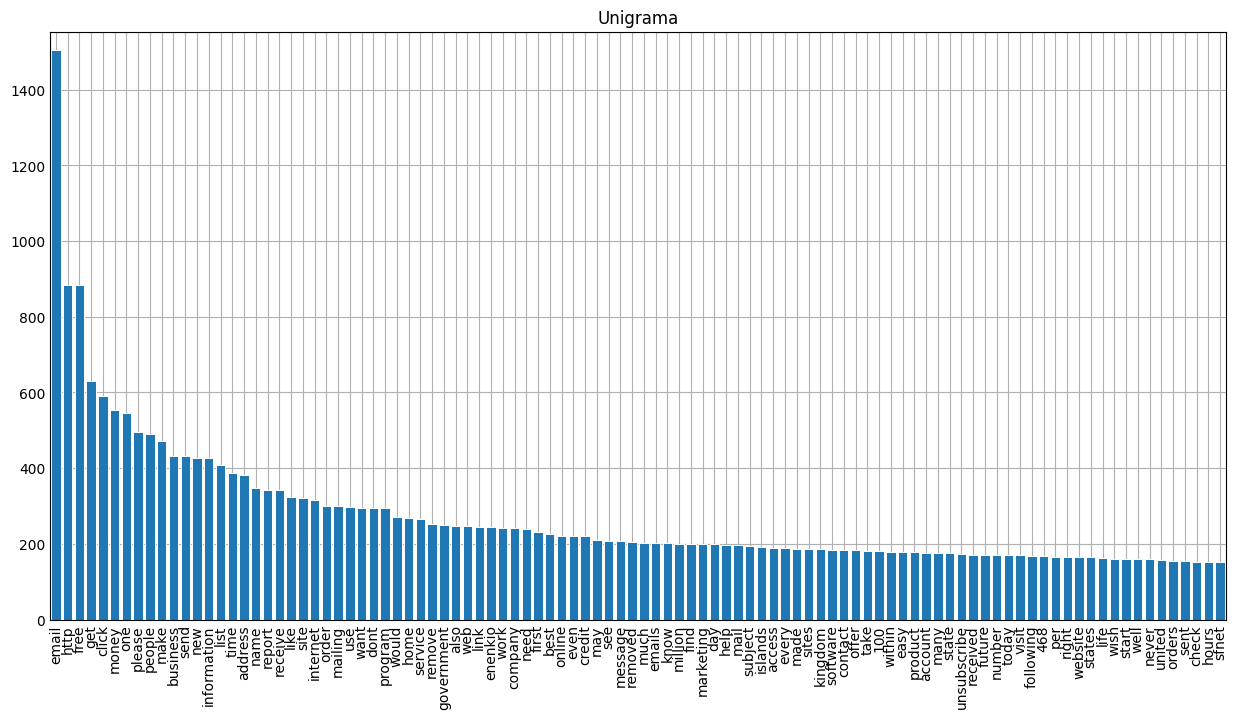

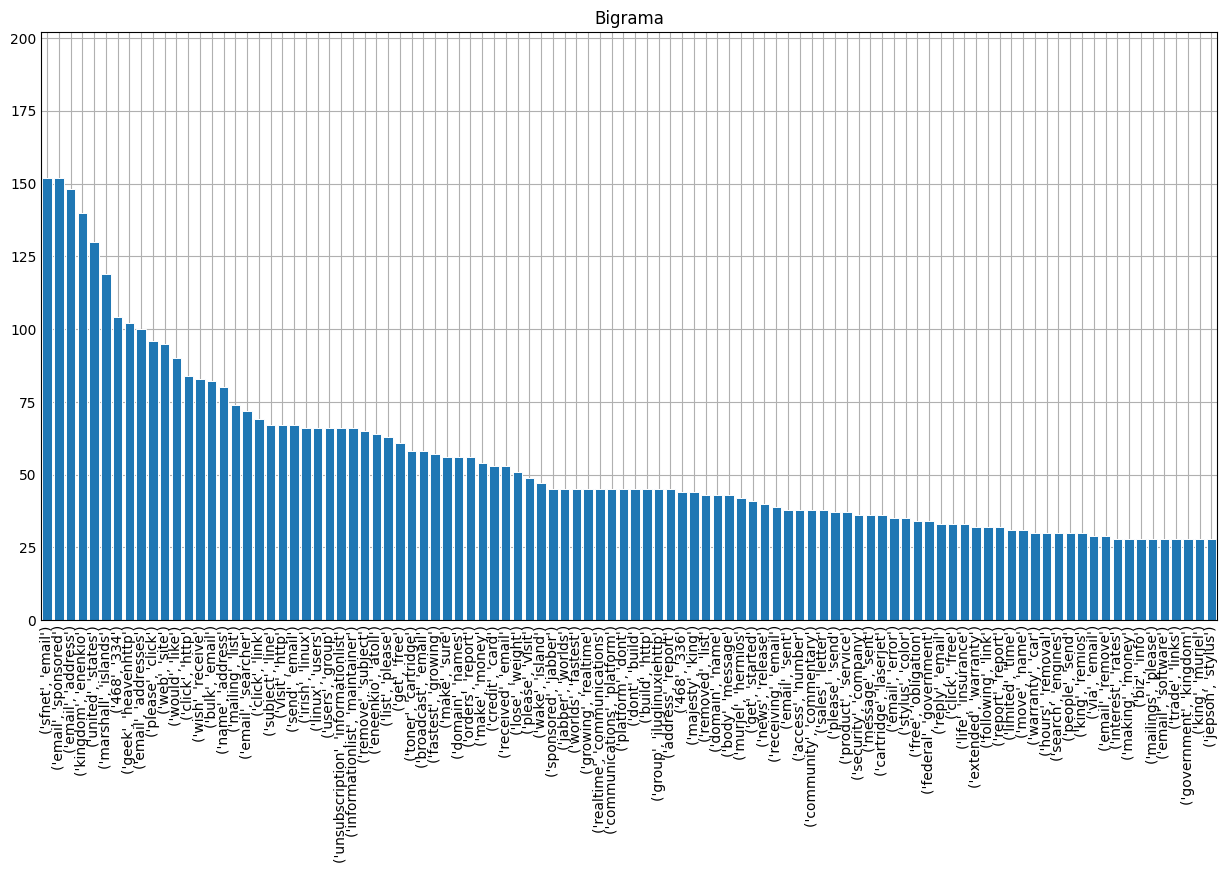

In [18]:
Phishing_email_processed = processar_dataset(nome_dataset, "Phishing Email")

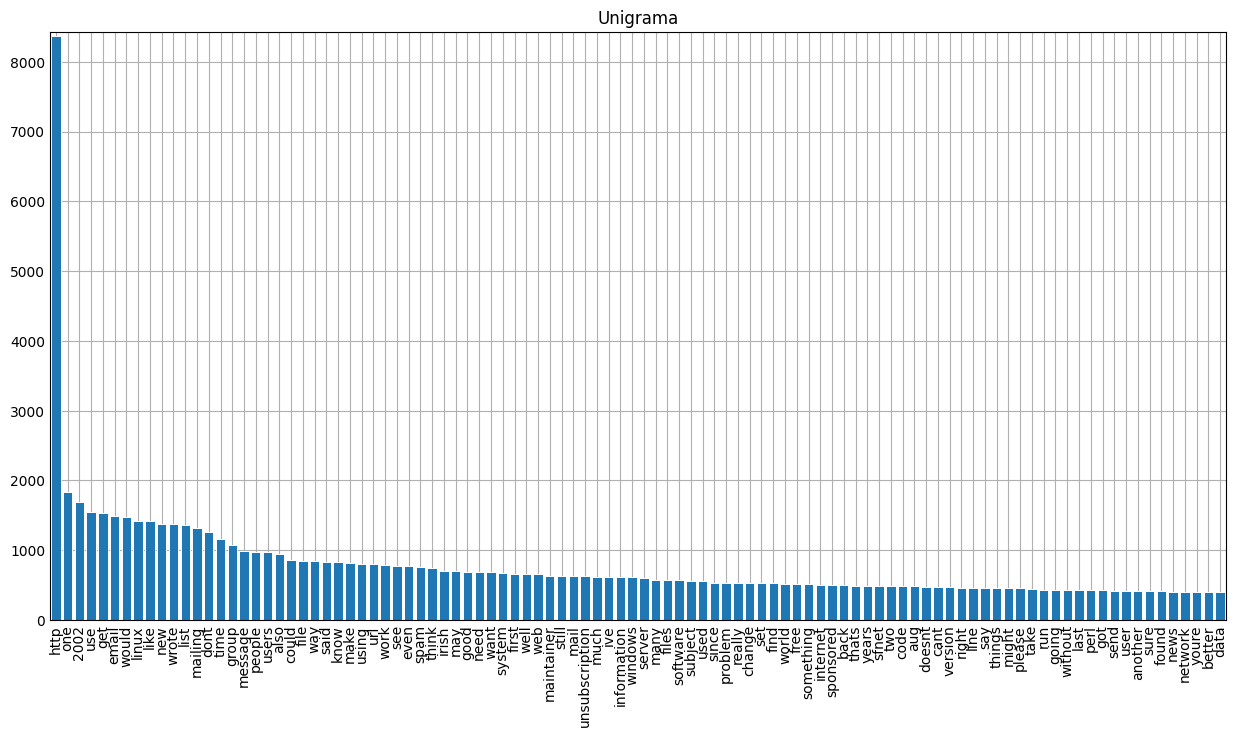

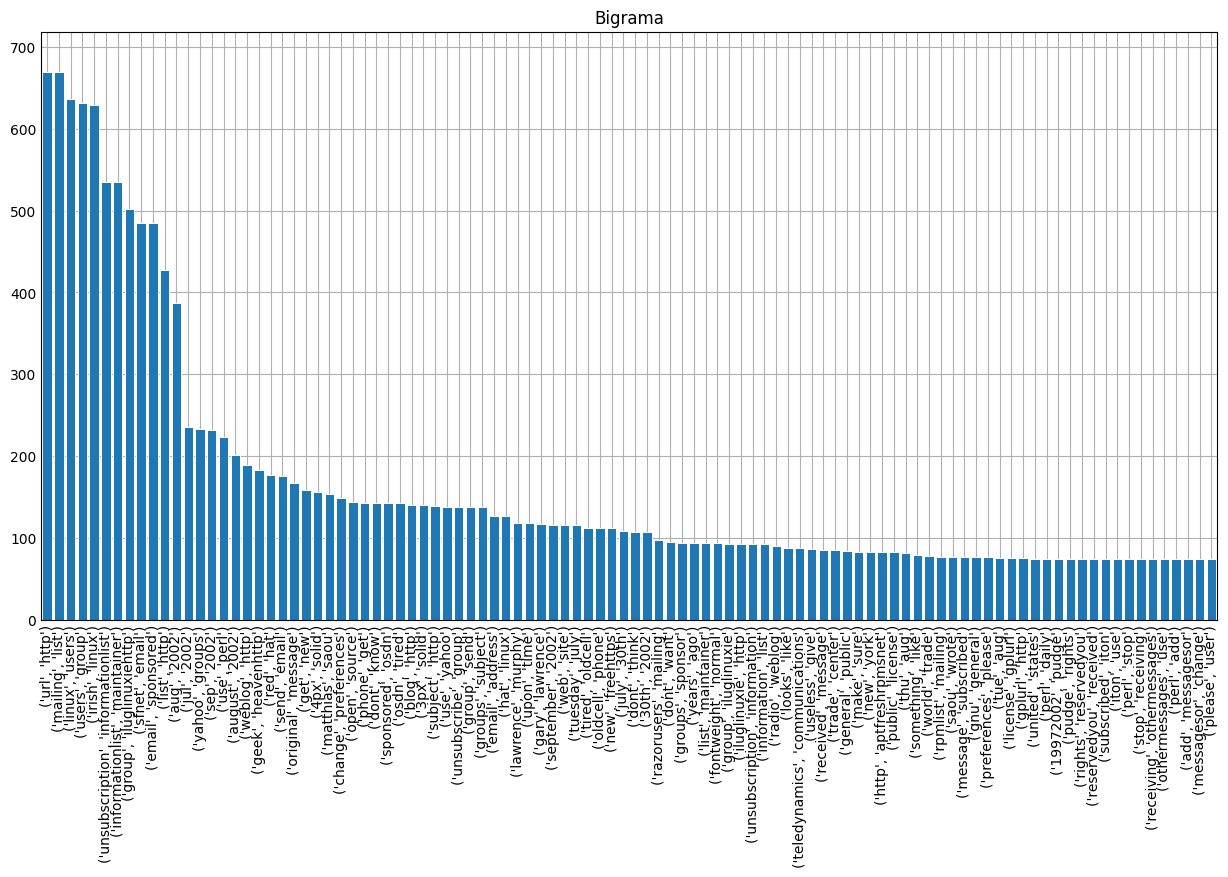

In [19]:
Safe_email_processed = processar_dataset(nome_dataset, "Safe Email")

In [20]:
# Palavras mais frequêntes nos emails de phishing do dataset utilizado
# Caminho do arquivo CSV
dataset_path = "/content/emails_phishing.csv"

# Carregar os dados
df = pd.read_csv(dataset_path)

# Supondo que cada linha já contenha palavras tokenizadas e processadas em formato de string
palavras_phishing = []

for mensagem in df.iloc[:, 0].dropna():  # Usa apenas a primeira coluna e remove NaN
    palavras_phishing.extend(mensagem.split())  # Assume que as palavras estão separadas por espaço

# Contagem de frequência
contador = Counter(palavras_phishing)
freq_palavras = pd.DataFrame(contador.most_common(200), columns=["Palavra", "Frequência"])

# Salvar e exibir os resultados
freq_palavras.to_csv("palavras_frequentes.csv", index=False)
freq_palavras.head(100)

,Palavra,Frequência
0,email,6390
1,free,3985
2,com,3974
3,company,3800
4,get,3727
...,...,...
95,received,1062
96,security,1060
97,subject,1058
98,without,1047


## **Treinamento**

In [21]:
palavras_phishing = ["future", "investment", "product", "milion", "online", "price", "receive", "name", "make", "free", "phone", "urgent", "software", "money", "buy", "information", "password", "click", "account", "verify", "login", "bank", "security", "update", "payment", "statements"]
palavras_seguras = ["meeting", "report", "team", "project", "deadline", "client", "agenda", "schedule", "feedback", "progress"]

dados_phishing = pd.DataFrame({"texto": palavras_phishing, "label": 1})
dados_seguros = pd.DataFrame({"texto": palavras_seguras, "label": 0})
dados = pd.concat([dados_phishing, dados_seguros], ignore_index=True)

# Vetorização do texto
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(dados["texto"])
y = dados["label"]

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinar o modelo
modelo = MultinomialNB() # testar outras variações - grid search
modelo.fit(X_train, y_train)

# Fazer previsões
y_pred = modelo.predict(X_test)

# Avaliar o modelo
print("Acurácia:", accuracy_score(y_test, y_pred))
print("\nRelatório de classificação:\n", classification_report(y_test, y_pred))
print("\nMatriz de Confusão:\n", confusion_matrix(y_test, y_pred))

Acurácia: 0.5

Relatório de classificação:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.50      1.00      0.67         4

    accuracy                           0.50         8
   macro avg       0.25      0.50      0.33         8
weighted avg       0.25      0.50      0.33         8


Matriz de Confusão:
 [[0 4]
 [0 4]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [22]:
# Função para pré-processar a mensagem
def preprocessar_mensagem(mensagem):
    # Aplica a mesma limpeza usada no treinamento do modelo
    mensagem_limpa = limpeza_dataset(mensagem)
    return mensagem_limpa

def avaliar_mensagem(mensagem, modelo, vectorizer):
    # Pré-processa a mensagem
    mensagem_preprocessada = preprocessar_mensagem(mensagem)

    # Vetoriza a mensagem usando o mesmo vetorizador do treinamento
    mensagem_vetorizada = vectorizer.transform([mensagem_preprocessada])

    # Faz a previsão
    previsao = modelo.predict(mensagem_vetorizada)

    return "Phishing" if previsao[0] == 1 else "Segura"

nova_mensagem = "Urgent: Your Account Has Been Compromised Dear Valued Customer, We have detected unusual activity on your account. To secure your account, please verify your identity by clicking the link below: Verify My Account Now If you do not take action within 24 hours, your account will be temporarily suspended. Thank you for your prompt attention to this matter. Sincerely, The Security Team"
resultado = avaliar_mensagem(nova_mensagem, modelo, vectorizer)
print(f"Classificação da mensagem: {resultado}")

Classificação da mensagem: Phishing


In [23]:
import joblib
joblib.dump(modelo, 'modelo_mensagens.pkl')
joblib.dump(vectorizer, 'vectorizer.pkl')

['vectorizer.pkl']

In [24]:
# Função para pré-processar a mensagem
def preprocessar_mensagem(mensagem):
    # Aplica a mesma limpeza usada no treinamento do modelo
    mensagem_limpa = limpeza_dataset(mensagem)
    return mensagem_limpa

def avaliar_mensagem(mensagem, modelo, vectorizer):
    # Pré-processa a mensagem
    mensagem_preprocessada = preprocessar_mensagem(mensagem)

    # Vetoriza a mensagem usando o mesmo vetorizador do treinamento
    mensagem_vetorizada = vectorizer.transform([mensagem_preprocessada])

    # Faz a previsão
    previsao = modelo.predict(mensagem_vetorizada)

    return "Phishing" if previsao[0] == 1 else "Segura"

resultado = []

with open('/content/emails_phishing.csv', 'r') as dataset:
    reader = csv.reader(dataset)
    for linha in reader:
      resultado.append(avaliar_mensagem(linha[0], modelo, vectorizer))
      # print(f"Classificação da mensagem: {resultado}")

for i in range(len(resultado)):
  print(f"Classificacao da mensagem {i}: {resultado[i]}")

Classificacao da mensagem 0: Phishing
Classificacao da mensagem 1: Phishing
Classificacao da mensagem 2: Phishing
Classificacao da mensagem 3: Phishing
Classificacao da mensagem 4: Phishing
Classificacao da mensagem 5: Phishing
Classificacao da mensagem 6: Phishing
Classificacao da mensagem 7: Phishing
Classificacao da mensagem 8: Phishing
Classificacao da mensagem 9: Phishing
Classificacao da mensagem 10: Phishing
Classificacao da mensagem 11: Phishing
Classificacao da mensagem 12: Phishing
Classificacao da mensagem 13: Phishing
Classificacao da mensagem 14: Phishing
Classificacao da mensagem 15: Phishing
Classificacao da mensagem 16: Phishing
Classificacao da mensagem 17: Phishing
Classificacao da mensagem 18: Phishing
Classificacao da mensagem 19: Phishing
Classificacao da mensagem 20: Phishing
Classificacao da mensagem 21: Phishing
Classificacao da mensagem 22: Phishing
Classificacao da mensagem 23: Phishing
Classificacao da mensagem 24: Phishing
Classificacao da mensagem 25: Phish

## **Análise de URLS**

In [25]:
def desencurtar_url(url_encurtada):
    try:
        # Faz uma requisição head para evitar baixar o conteúdo da página
        resposta = requests.head(url_encurtada, allow_redirects=True, timeout=10)
        # Retorna a url final após os redirecionamentos
        return resposta.url
    except requests.RequestException as e:
        print(f"Erro ao desencurtar a URL: {e}")
        return None

def analisar_url(url):
    pontuacao_maxima = 100
    pontuacao = pontuacao_maxima

    # Verifica se a url é de um encurtador de links comum
    encurtadores_comuns = ['abre.ai', 'bit.ly', 'tinyurl.com', 'goo.gl', 'ow.ly', 'is.gd', 'shorte.st']
    if any(encurtador in url for encurtador in encurtadores_comuns):
        print(f"A URL '{url}' é encurtada.")
        pontuacao -= 50  # Penaliza urls encurtadas
        url_real = desencurtar_url(url)
        if url_real:
            print(f"URL real encontrada: {url_real}")
            url = url_real  # Analisa a url real a partir deste ponto

    # Verifica o comprimento da URL
    if len(url) > 50:
        pontuacao -= 20
    elif len(url) > 30:
        pontuacao -= 10

    # Verifica a quantidade de subdomínios
    partes = url.split('.')
    if len(partes) > 3:
        pontuacao -= 15

    # Verifica o uso de caracteres especiais
    caracteres_especiais = re.findall(r'[^\w\-\.\/\:]', url)
    if len(caracteres_especiais) > 3:
        pontuacao -= 25

    # Verifica se a URL usa um protocolo seguro (HTTPS)
    if not url.startswith('https://'):
        pontuacao -= 10

    # Verifica se a URL contém termos suspeitos
    termos_suspeitos = ['login', 'secure', 'account', 'banking', 'update', 'verify']
    if any(termo in url.lower() for termo in termos_suspeitos):
        pontuacao -= 15

    # Verifica se o domínio é de alto risco
    dominios_alto_risco = ['.tk', '.ml', '.ga', '.cf', '.gq']
    if any(dominio in url for dominio in dominios_alto_risco):
        pontuacao -= 20

    # Garante que a pontuação não seja negativa
    pontuacao = max(pontuacao, 0)

    # Calcula a taxa de confiança
    taxa_confianca = (pontuacao / pontuacao_maxima) * 100
    return taxa_confianca

In [26]:
resultado2_urls = []

with open('/content/Safe Email_urls.csv', 'r') as dataset:
    reader = csv.reader(dataset)
    for linha in reader:
      resultado2_urls.append(analisar_url(linha[0]))

for i in range(len(resultado2_urls)):
  print(f"Taxa de confiança de url_'{i}': {resultado2_urls[i]:.1f}%")

Taxa de confiança de url_'0': 80.0%
Taxa de confiança de url_'1': 80.0%
Taxa de confiança de url_'2': 55.0%
Taxa de confiança de url_'3': 55.0%
Taxa de confiança de url_'4': 90.0%
Taxa de confiança de url_'5': 30.0%
Taxa de confiança de url_'6': 80.0%
Taxa de confiança de url_'7': 70.0%
Taxa de confiança de url_'8': 80.0%
Taxa de confiança de url_'9': 90.0%
Taxa de confiança de url_'10': 55.0%
Taxa de confiança de url_'11': 80.0%
Taxa de confiança de url_'12': 80.0%
Taxa de confiança de url_'13': 80.0%
Taxa de confiança de url_'14': 65.0%
Taxa de confiança de url_'15': 90.0%
Taxa de confiança de url_'16': 80.0%
Taxa de confiança de url_'17': 80.0%
Taxa de confiança de url_'18': 55.0%
Taxa de confiança de url_'19': 70.0%
Taxa de confiança de url_'20': 55.0%
Taxa de confiança de url_'21': 80.0%
Taxa de confiança de url_'22': 80.0%
Taxa de confiança de url_'23': 80.0%
Taxa de confiança de url_'24': 90.0%
Taxa de confiança de url_'25': 65.0%
Taxa de confiança de url_'26': 70.0%
Taxa de con

## **Análise de URLS (Current version)**
Dataset utilizado: https://data.mendeley.com/datasets/vfszbj9b36/1/files/f0de314f-ea72-4385-9faa-f06593bb0a2d

In [27]:
import pandas as pd
from urllib.parse import urlparse
import re
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Função para extrair características das URLs
def extrair_caracteristicas(url):
    caracteristicas = {}

    # Comprimento da URL
    caracteristicas["comprimento"] = len(url)

    # Número de subdomínios
    try:
        parsed_url = urlparse(url)
        dominio = parsed_url.netloc
        caracteristicas["num_subdominios"] = dominio.count('.') if dominio else 0

        # Presença de IP no domínio
        caracteristicas["tem_ip"] = 1 if re.match(r"\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}", dominio) else 0

        # Presença de caracteres especiais
        caracteristicas["tem_caracteres_especiais"] = 1 if re.search(r"[@_\-]", url) else 0

        # Extensão do domínio
        extensao = dominio.split('.')[-1] if dominio else ""
        caracteristicas["extensao_suspeita"] = 1 if extensao not in ["com", "org", "net", "gov", "edu"] else 0

        # Comprimento do caminho
        caminho = parsed_url.path
        caracteristicas["comprimento_caminho"] = len(caminho)

        # Presença de palavras-chave suspeitas
        palavras_chave = ["login", "secure", "verify", "account", "bank", "paypal"]
        caracteristicas["palavras_chave_suspeitas"] = sum(1 for palavra in palavras_chave if palavra in url.lower())
    except Exception as e:
        # Se houver erro, define valores padrão
        caracteristicas["num_subdominios"] = 0
        caracteristicas["tem_ip"] = 0
        caracteristicas["tem_caracteres_especiais"] = 0
        caracteristicas["extensao_suspeita"] = 0
        caracteristicas["comprimento_caminho"] = 0
        caracteristicas["palavras_chave_suspeitas"] = 0

    return caracteristicas

# Carregar URLs de phishing
urls_phishing = pd.read_csv('/content/Dataset/Phishing URLs.csv')
urls_phishing["label"] = 1  # 1 para phishing

# Carregar URLs seguras
urls_seguras = pd.read_csv('/content/Dataset/Legitimate URLs.csv')
urls_seguras["label"] = 0  # 0 para URLs seguras

# Combinar os datasets
dados_urls = pd.concat([urls_phishing, urls_seguras], ignore_index=True)

# Extrair características
dados_urls["caracteristicas"] = dados_urls["url"].apply(extrair_caracteristicas)
caracteristicas_df = pd.DataFrame(dados_urls["caracteristicas"].tolist())
dados_finais = pd.concat([caracteristicas_df, dados_urls["label"]], axis=1)

# Dividir os dados em treino e teste
X = dados_finais.drop("label", axis=1)
y = dados_finais["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinar o modelo
modelo_urls = RandomForestClassifier(random_state=42)
modelo_urls.fit(X_train, y_train)

# Fazer previsões
y_pred = modelo_urls.predict(X_test)

# Avaliar o modelo
print("Acurácia:", accuracy_score(y_test, y_pred))
print("\nRelatório de classificação:\n", classification_report(y_test, y_pred))
print("\nMatriz de Confusão:\n", confusion_matrix(y_test, y_pred))

# Validação cruzada
scores = cross_val_score(modelo_urls, X, y, cv=5, scoring='accuracy')
print("\nAcurácia com validação cruzada:", scores.mean())

# Função para classificar novas URLs
def classificar_url(url, modelo):
    # Extrair características da URL
    caracteristicas = extrair_caracteristicas(url)
    caracteristicas_df = pd.DataFrame([caracteristicas])

    # Fazer a previsão
    previsao = modelo.predict(caracteristicas_df)

    return "URL Falsa (Phishing)" if previsao[0] == 1 else "URL Segura"

# Testar com uma URL de phishing do dataset
url_phishing_teste = urls_phishing.sample(1)["url"].values[0]
resultado = classificar_url(url_phishing_teste, modelo_urls)
print(f"\nClassificação da URL de phishing: {resultado}")
print(f"URL de phishing usada: {url_phishing_teste}")

# Testar com uma URL segura do dataset
url_segura_teste = urls_seguras.sample(1)["url"].values[0]
resultado = classificar_url(url_segura_teste, modelo_urls)
print(f"\nClassificação da URL segura: {resultado}")
print(f"URL segura usada: {url_segura_teste}")

Acurácia: 0.9487311504302108

Relatório de classificação:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97     90043
           1       0.81      0.69      0.75     10954

    accuracy                           0.95    100997
   macro avg       0.89      0.84      0.86    100997
weighted avg       0.95      0.95      0.95    100997


Matriz de Confusão:
 [[88246  1797]
 [ 3381  7573]]

Acurácia com validação cruzada: 0.9041232860027177

Classificação da URL de phishing: URL Falsa (Phishing)
URL de phishing usada: https://seoservicesiox.firebaseapp.com/%3ferr%3db0qmbz0rr7j7jwfxwuge2mltlfh8thi44wlmqjgij0fh5stc48aquvtmcruyumz2niptbupveoc1ahjudxaismgkdfdtvx618o8ezh9u7tzegmvb8jrkdizlrvw37e9esh2ja0lqhmdk4d9nhba61p7aog7q7cajiv6ajsm2dmmibnnyz2a23ofr9c71ddkltw1hm90vgwp4idx8608jvjqhobitxvpl3lmkole2%26dispatch%3d63dd06g4i54iii7bd08efj53g3kd9a%26id%3dfde8bdb7958c?err=g5iyf49QIQkhm5GPy8CtXd5NdiF46jd&err=g5iyf49QIQkhm5GPy8CtXd5NdiF46jd&dispatch=1b3g

In [28]:
nova_url = "https://anoe.co.jp.iqgnnjo.cn/aeon"
resultado = classificar_url(nova_url, modelo_urls)
print(f"Classificação da URL: {resultado}")

Classificação da URL: URL Falsa (Phishing)


In [29]:
import joblib
joblib.dump(modelo_urls, 'modelo_urls.pkl')

['modelo_urls.pkl']

## **Interface Gráfica**

In [30]:
!pip install gradio

In [34]:
import gradio as gr
import joblib
import pandas as pd
from urllib.parse import urlparse
import re
from sklearn.feature_extraction.text import CountVectorizer

# CSS personalizado
custom_css = """
@import url('https://fonts.googleapis.com/css2?family=Montserrat:wght@400;700&display=swap');

body, .gradio-container {
    font-family: 'Montserrat', sans-serif !important;
}

h1, h2, h3, h4, h5, h6 {
    font-family: 'Montserrat', sans-serif !important;
    font-weight: 700 !important;
}

label, .dropdown, .button, .textbox {
    font-family: 'Montserrat', sans-serif !important;
}
"""

# Função para extrair características das URLs
def extrair_caracteristicas(url):
    caracteristicas = {}

    # Comprimento da URL
    caracteristicas["comprimento"] = len(url)

    # Número de subdomínios
    try:
        parsed_url = urlparse(url)
        dominio = parsed_url.netloc
        caracteristicas["num_subdominios"] = dominio.count('.') if dominio else 0

        # Presença de IP no domínio
        caracteristicas["tem_ip"] = 1 if re.match(r"\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}", dominio) else 0

        # Presença de caracteres especiais
        caracteristicas["tem_caracteres_especiais"] = 1 if re.search(r"[@_\-]", url) else 0

        # Extensão do domínio
        extensao = dominio.split('.')[-1] if dominio else ""
        caracteristicas["extensao_suspeita"] = 1 if extensao not in ["com", "org", "net", "gov", "edu"] else 0

        # Comprimento do caminho
        caminho = parsed_url.path
        caracteristicas["comprimento_caminho"] = len(caminho)

        # Presença de palavras-chave suspeitas
        palavras_chave = ["login", "secure", "verify", "account", "bank", "paypal"]
        caracteristicas["palavras_chave_suspeitas"] = sum(1 for palavra in palavras_chave if palavra in url.lower())
    except Exception as e:
        # Se houver erro, define valores padrão
        caracteristicas["num_subdominios"] = 0
        caracteristicas["tem_ip"] = 0
        caracteristicas["tem_caracteres_especiais"] = 0
        caracteristicas["extensao_suspeita"] = 0
        caracteristicas["comprimento_caminho"] = 0
        caracteristicas["palavras_chave_suspeitas"] = 0

    return caracteristicas

# Função para classificar URLs com confiança
def classificar_url_com_confianca(url, modelo_urls):
    try:
        # Extrai características da URL
        caracteristicas = extrair_caracteristicas(url)
        caracteristicas_df = pd.DataFrame([caracteristicas])

        # Faz a previsão e obtem as probabilidades
        probabilidades = modelo_urls.predict_proba(caracteristicas_df)
        previsao = modelo_urls.predict(caracteristicas_df)

        # Determina a classe e a confiança
        if previsao[0] == 1:
            classe = "URL Falsa (Phishing)"
            confianca = probabilidades[0][1] * 100  # Probabilidade de ser phishing
        else:
            classe = "URL Segura"
            confianca = probabilidades[0][0] * 100  # Probabilidade de ser segura

        return classe, confianca
    except Exception as e:
        return f"Erro ao classificar URL: {str(e)}", 0

# Função para classificar mensagens com confiança
def classificar_mensagem_com_confianca(mensagem, modelo_mensagens, vectorizer):
    try:
        # Vetoriza a mensagem
        mensagem_vetorizada = vectorizer.transform([mensagem])

        # Faz a previsão e obtem as probabilidades
        probabilidades = modelo_mensagens.predict_proba(mensagem_vetorizada)
        previsao = modelo_mensagens.predict(mensagem_vetorizada)

        # Determina a classe e a confiança
        if previsao[0] == 1:
            classe = "Mensagem de Phishing"
            confianca = probabilidades[0][1] * 100  # Probabilidade de ser phishing
        else:
            classe = "Mensagem Segura"
            confianca = probabilidades[0][0] * 100  # Probabilidade de ser segura

        return classe, confianca
    except Exception as e:
        return f"Erro ao classificar mensagem: {str(e)}", 0

# Função principal para a interface do Gradio
def analisar(mensagem, url):
    try:
        # Carrega os modelos e o vetorizador (substitua pelos caminhos corretos)
        modelo_urls = joblib.load('modelo_urls.pkl')  # Modelo para URLs
        modelo_mensagens = joblib.load('modelo_mensagens.pkl')  # Modelo para mensagens
        vectorizer = joblib.load('vectorizer.pkl')  # Vetorizador para mensagens

        # Inicializa os resultados
        resultado_mensagem = ""
        resultado_url = ""

        # Classifica a mensagem (se houver conteúdo)
        if mensagem.strip():
            classe_mensagem, confianca_mensagem = classificar_mensagem_com_confianca(mensagem, modelo_mensagens, vectorizer)
            resultado_mensagem = f"{classe_mensagem} - {confianca_mensagem:.2f}% de confiança"
        else:
            resultado_mensagem = "Nenhuma mensagem fornecida."

        # Classifica a URL (se houver conteúdo)
        if url.strip():
            classe_url, confianca_url = classificar_url_com_confianca(url, modelo_urls)
            resultado_url = f"{classe_url} - {confianca_url:.2f}% de confiança"
        else:
            resultado_url = "Nenhuma URL fornecida."

        return resultado_mensagem, resultado_url
    except Exception as e:
        return f"Erro geral: {str(e)}", f"Erro geral: {str(e)}"

# Cria a interface do Gradio com tema e CSS personalizado
with gr.Blocks(theme=gr.themes.Soft(primary_hue="blue", secondary_hue="gray"), css=custom_css) as app:

    logo1 = "https://institucional.ufpel.edu.br/img/marca-ufpel.png"
    logo2 = "https://wp.ufpel.edu.br/gepesc/files/2024/10/GEPESC-positvpng-e1741530249634.png"

    # Adiciona as logos lado a lado
    with gr.Row():
        gr.Image(value=logo1, height=100, show_label=False)
        gr.Image(value=logo2, height=100, show_label=False)

    # Título
    gr.Markdown("# Verificador de Phishing")
    gr.Markdown("Insira uma mensagem e/ou uma URL para verificar se são seguras ou phishing.")

    # Campos de entrada
    with gr.Column():
        mensagem = gr.Textbox(label="Mensagem")
        url = gr.Textbox(label="URL")

    # Botão de análise
    botao_analisar = gr.Button("Analisar", variant="primary")

    # Resultados
    with gr.Column():
        resultado_mensagem = gr.Textbox(label="Resultado da Mensagem", interactive=False)
        resultado_url = gr.Textbox(label="Resultado da URL", interactive=False)

    # Conecta o botão à função de análise
    botao_analisar.click(
        fn=analisar,
        inputs=[mensagem, url],
        outputs=[resultado_mensagem, resultado_url]
    )

# Inicia a interface
app.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a8f4f2a16f3bc4ff72.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
